# Sprawozdanie - MOwNiT - laboratorium 4., zadanie 2.

#### Autor: Jakub Psarski

## Obraz binarny

Wygeneruj losowy obraz binarny o rozmiarze $n \times n$ i wybranej gęstości $δ$ czarnych punktów $δ = 0.1, 0.3, 0.4$. Korzystając z różnego typu sąsiedztwa (4-sąsiadów, 8-sąsiadów, 8-16-sąsiadów) zaproponuj funkcję energii (np. w bliskiej odległości te same kolory przyciągają się, a w dalszej odpychają się, funkcja energii może być również adaptacją modelu Isinga) i dokonaj jej minimalizacji za pomocą algorytmu symulowanego wyżarzania. W jaki sposób można generować stany sąsiednie? Jak różnią się uzyskane wyniki w zależności od rodzaju sąsiedztwa, wybranej funkcji energii i szybkości spadku temperatury?

### 1. Importowanie potrzebnych bibliotek

In [6]:
import time

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from IPython.display import HTML, display
from matplotlib import animation, rcParams

rcParams['animation.embed_limit'] = 200

### 2. Implementacja algorytmu symulowanego wyżarzania dla przetwarzania obrazu binarnego

In [5]:
def simulated_annealing(image, neighborhood_type, energy_function,
                        temperature=100.0, cooling_rate=0.999, threshold=1e-8):
    """
    Performs simulated annealing process for a binary image.
    """
    n = image.shape[0]
    current_energy = energy_function(image, neighborhood_type)

    best_image = image.copy()
    best_energy = current_energy

    energy_history = [current_energy]

    while temperature > threshold:
        x = np.random.randint(0, n), np.random.randint(0, n)
        y = np.random.randint(0, n), np.random.randint(0, n)
        while image[x] == image[y]:
            y = np.random.randint(0, n), np.random.randint(0, n)

        new_image = image.copy()
        new_image[x], new_image[y] = new_image[y], new_image[x]

        new_energy = energy_function(new_image, neighborhood_type)
        delta_energy = new_energy - current_energy

        if delta_energy < 0 or np.random.random() < np.exp(-delta_energy / temperature):
            image = new_image.copy()
            current_energy = new_energy

            if current_energy < best_energy:
                best_image = image.copy()
                best_energy = current_energy

        temperature *= cooling_rate
        energy_history.append(current_energy)

    return best_image, energy_history


def simulated_annealing_vis(image, neighborhood_type, energy_function,
                        temperature=100.0, cooling_rate=0.999, threshold=1e-8):
    """
    Performs simulated annealing process and collects data for animation.
    """
    n = image.shape[0]
    current_energy = energy_function(image, neighborhood_type)
    best_energy = current_energy

    images = [image.copy()]

    i = 0
    while temperature > threshold:
        x = np.random.randint(0, n), np.random.randint(0, n)
        y = np.random.randint(0, n), np.random.randint(0, n)
        while image[x] == image[y]:
            y = np.random.randint(0, n), np.random.randint(0, n)

        new_image = image.copy()
        new_image[x], new_image[y] = new_image[y], new_image[x]

        new_energy = energy_function(new_image, neighborhood_type)
        delta_energy = new_energy - current_energy

        if delta_energy < 0 or np.random.random() < np.exp(-delta_energy / temperature):
            image = new_image.copy()
            current_energy = new_energy

            best_energy = min(best_energy, current_energy)

        images.append(image.copy())
        temperature *= cooling_rate
        i += 1

    return images


### 3. Funkcje energii

- `energy_clusters()` - sąsiadujące piksele z tymi samymi wartościami zmniejszają energię

In [2]:
def energy_clusters(image, neighborhood_type):
    """
    Calculates the energy of the image (neighboring pixels of the same value decrease energy).
    """
    n = image.shape[0]
    energy = 0

    for i in range(n):
        for j in range(n):
            neighbors = get_neighbors(i, j, n, neighborhood_type)
            for ni, nj in neighbors:
                if image[i, j] != image[ni, nj]:
                    energy += 1.0

    return energy

- `energy_distance()` - sąsiadujące piksele z tymi samymi wartościami zmniejszają energię o wartość zależną od odległości między nimi

In [3]:
def energy_distance(image, neighborhood_type):
    """
    Calculates the energy of the image (neighboring pixels of the same value decrease energy
    depending on the distance between them).
    """
    n = image.shape[0]
    energy = 0

    for i in range(n):
        for j in range(n):
            pixel_value = image[i, j]
            neighbors = get_neighbors(i, j, n, neighborhood_type)

            for ni, nj in neighbors:
                neighbor_value = image[ni, nj]

                distance = np.sqrt((i - ni)**2 + (j - nj)**2)

                if pixel_value != neighbor_value:
                    energy += 1.0 / distance

    return energy

- `energy_vertical_neighbors()` - piksele sąsiadujące ze sobą w poziomie zwiększają energię - piksele układają się w pionowe paski

In [4]:
def energy_vertical_neighbors(image, neighborhood_type):
    """
    Calculates the energy of the image (vertical neighboring pixels change energy).
    """
    n = image.shape[0]
    energy = 0

    for i in range(n):
        for j in range(n):
            neighbors = get_neighbors(i, j, n, neighborhood_type)
            for ni, nj in neighbors:
                if (j != nj) and image[i, j] == image[ni, nj]:
                    energy += 1.0

    return energy

### 4. Funkcje pomocnicze

- `generate_binary_image()` - generowanie obrazu binarnego o podanych wymiarach i gęstości czarnych pikseli

In [9]:
def generate_binary_image(n, density):
    """
    Generates a random binary image of size n x n with a given density of black pixels.
    """
    random_values = np.random.random((n, n))
    binary_image = np.zeros((n, n), dtype=int)
    binary_image[random_values < density] = 1
    return binary_image

- `get_neighbors()` - generowanie listy sąsiadów podanego piksela zgodnie z podanym typem sąsiedztwa

In [10]:
def get_neighbors(i, j, n, neighborhood_type):
    """
    Returns the indices of neighbors of pixel (i, j) according to the selected neighborhood type.
    """
    neighbors = []

    # Up, down, left, right
    four_neighbors = [
        (i-1, j), (i+1, j), (i, j-1), (i, j+1)
    ]

    # Above + corners
    eight_neighbors = four_neighbors + [
        (i-1, j-1), (i-1, j+1), (i+1, j-1), (i+1, j+1)
    ]

    # Above + further pixels
    sixteen_neighbors = eight_neighbors + [
        (i-2, j), (i+2, j), (i, j-2), (i, j+2),
        (i-2, j-1), (i-2, j+1), (i+2, j-1), (i+2, j+1),
        (i-1, j-2), (i+1, j-2), (i-1, j+2), (i+1, j+2)
    ]

    if neighborhood_type == '4':
        potential_neighbors = four_neighbors
    elif neighborhood_type == '8':
        potential_neighbors = eight_neighbors
    elif neighborhood_type == '8-16':
        potential_neighbors = sixteen_neighbors
    else:
        raise ValueError("Unknown neighborhood type")

    # Neighbors within bounds
    for ni, nj in potential_neighbors:
        if 0 <= ni < n and 0 <= nj < n:
            neighbors.append((ni, nj))

    return neighbors

- `visualize_results()` - wizualizacja wyników przetwarzania obrazu

In [8]:
def visualize_results(original_image, optimized_image, energy_history, title):
    """
    Visualizes the results of simulated annealing.
    """
    _, axs = plt.subplots(1, 3, figsize=(18, 6))

    cmap = ListedColormap(['white', 'black'])

    axs[0].imshow(original_image, cmap=cmap)
    axs[0].set_title('Original image')
    axs[0].axis('off')

    axs[1].imshow(optimized_image, cmap=cmap)
    axs[1].set_title('Optimized image')
    axs[1].axis('off')

    axs[2].plot(energy_history)
    axs[2].set_title('Energy through iterations')
    axs[2].set_xlabel('Iteration')
    axs[2].set_ylabel('Energy')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

- `animate()` - animacja procesu wyżarzania na obrazie bitowym

In [14]:
def animate(images, energy_function, neighborhood_type, framerate=30):
    """Create an animation of image processing."""
    print("Creating animation...")

    best_energy = float('inf')
    cmap = ListedColormap(['white', 'black'])

    def update(frame):
        nonlocal best_energy
        current_energy = energy_function(frame, neighborhood_type)
        best_energy = min(best_energy, current_energy)

        ax.clear()
        ax.set_title(f"Current energy: {current_energy:.2f}, Best energy: {best_energy:.2f}")
        ax.set_xticks([])
        ax.set_yticks([])

        ax.imshow(frame, cmap=cmap)

    fig, ax = plt.subplots(figsize=(8, 8))
    step = len(images) // 200
    fr = images[::step]

    anim = animation.FuncAnimation(
        fig, update, frames=fr, interval=1000//framerate, repeat=False
    )

    plt.close(fig)

    return HTML(anim.to_html5_video())


### 5. Wyniki, czasy działania, wizualizacja

#### 5.1. Porównanie obrazu przed i po przetwarzaniu, wykresy energii

Neighborhood: 4, Cooling rate: 0.99, Energy function: clusters
Initial energy: 4756.0
Final energy: 3108.0
Total elapsed time: 16.32 s



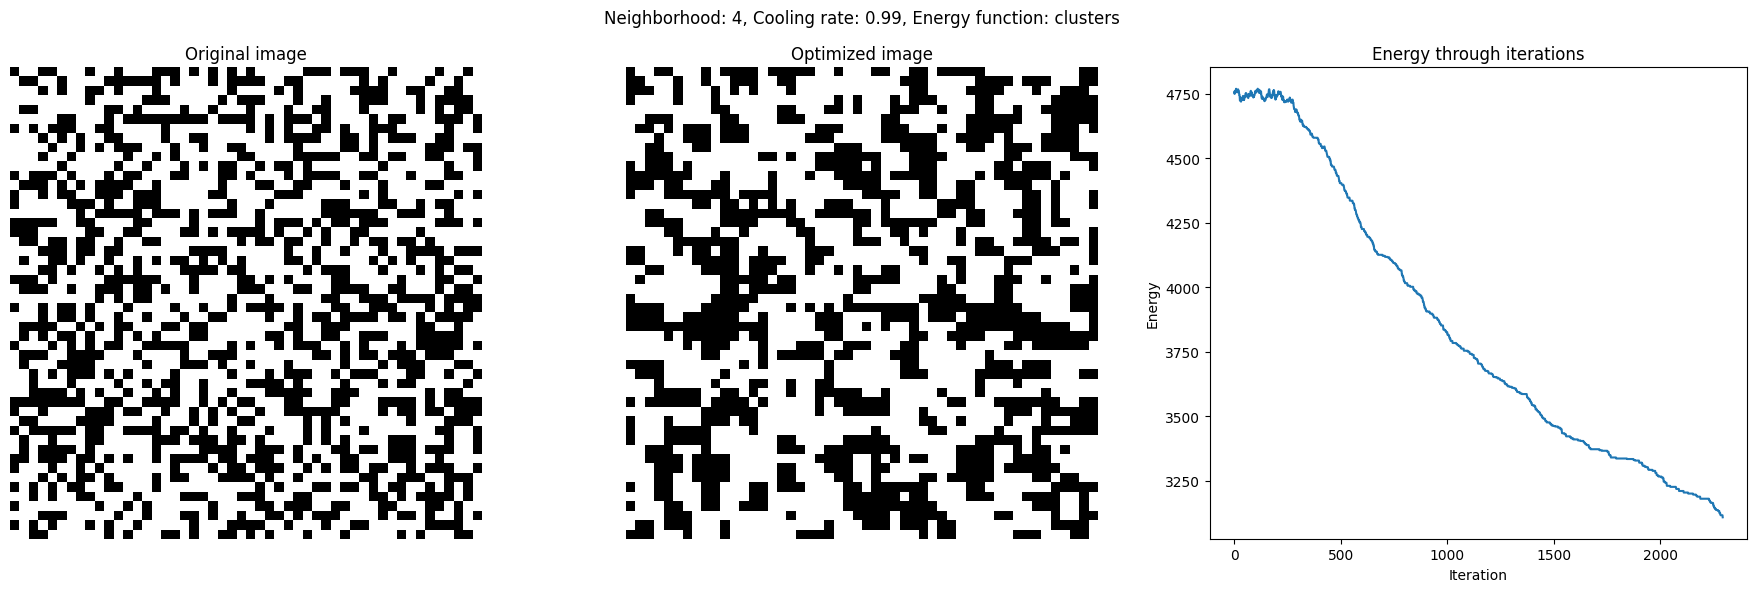

Neighborhood: 4, Cooling rate: 0.99, Energy function: distance
Initial energy: 4756.0
Final energy: 3012.0
Total elapsed time: 57.66 s



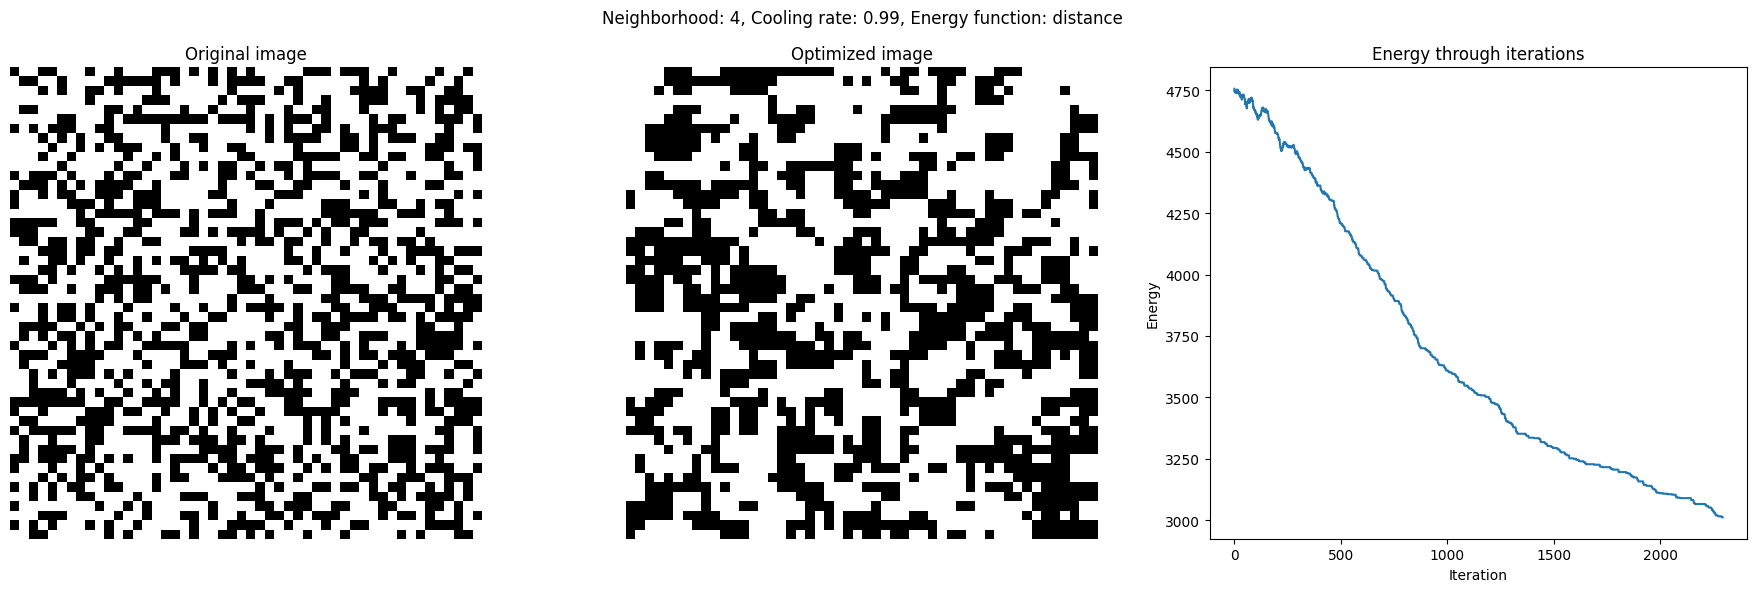

Neighborhood: 4, Cooling rate: 0.99, Energy function: vertical_neighbors
Initial energy: 2556.0
Final energy: 1406.0
Total elapsed time: 13.82 s



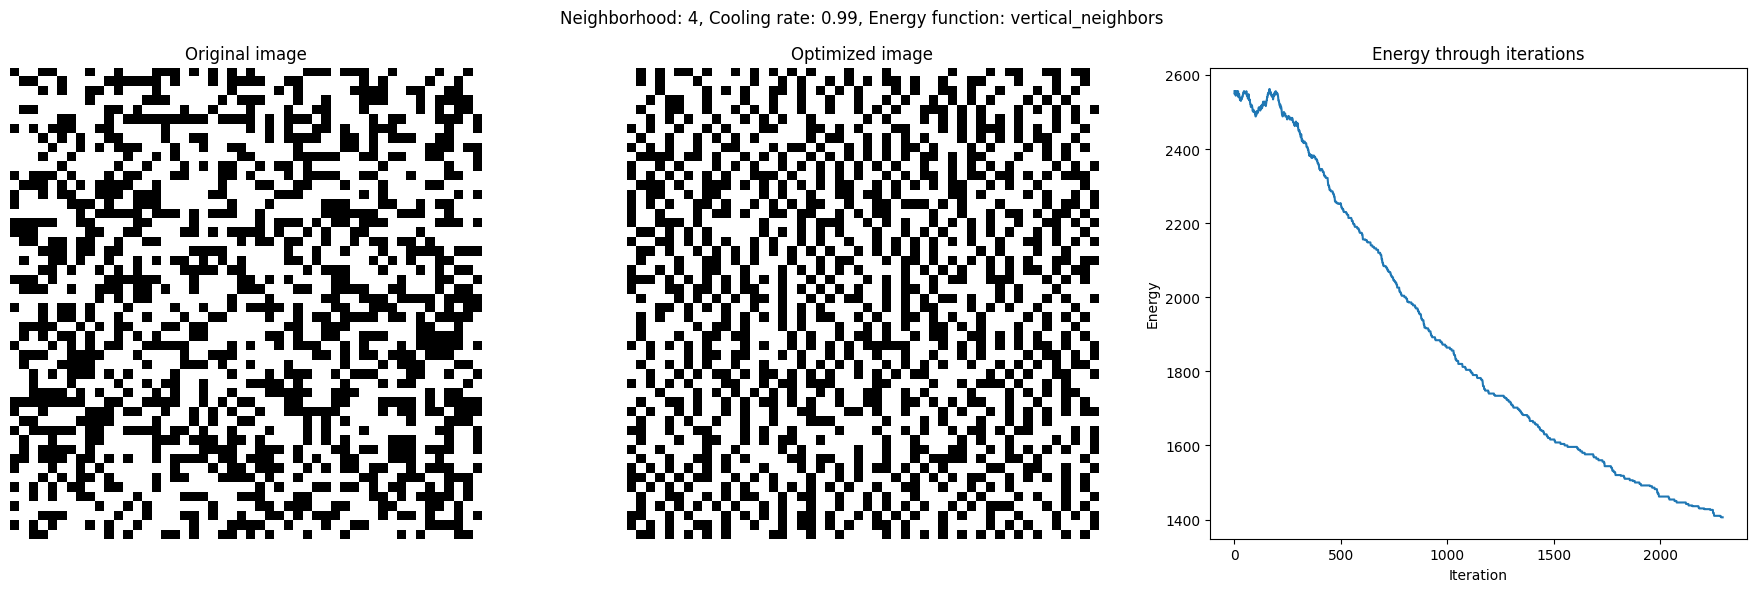

Neighborhood: 4, Cooling rate: 0.995, Energy function: clusters
Initial energy: 4756.0
Final energy: 2474.0
Total elapsed time: 33.34 s



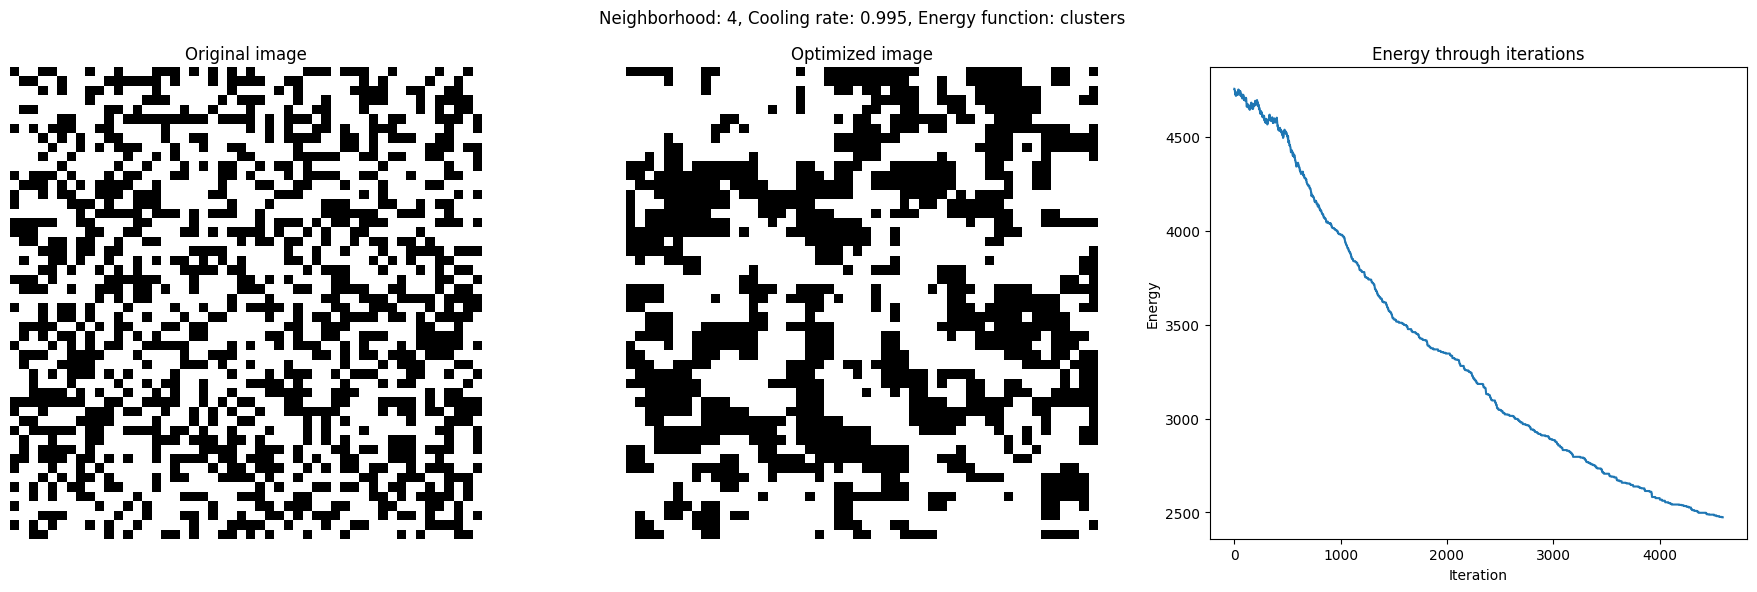

Neighborhood: 4, Cooling rate: 0.995, Energy function: distance
Initial energy: 4756.0
Final energy: 2410.0
Total elapsed time: 115.67 s



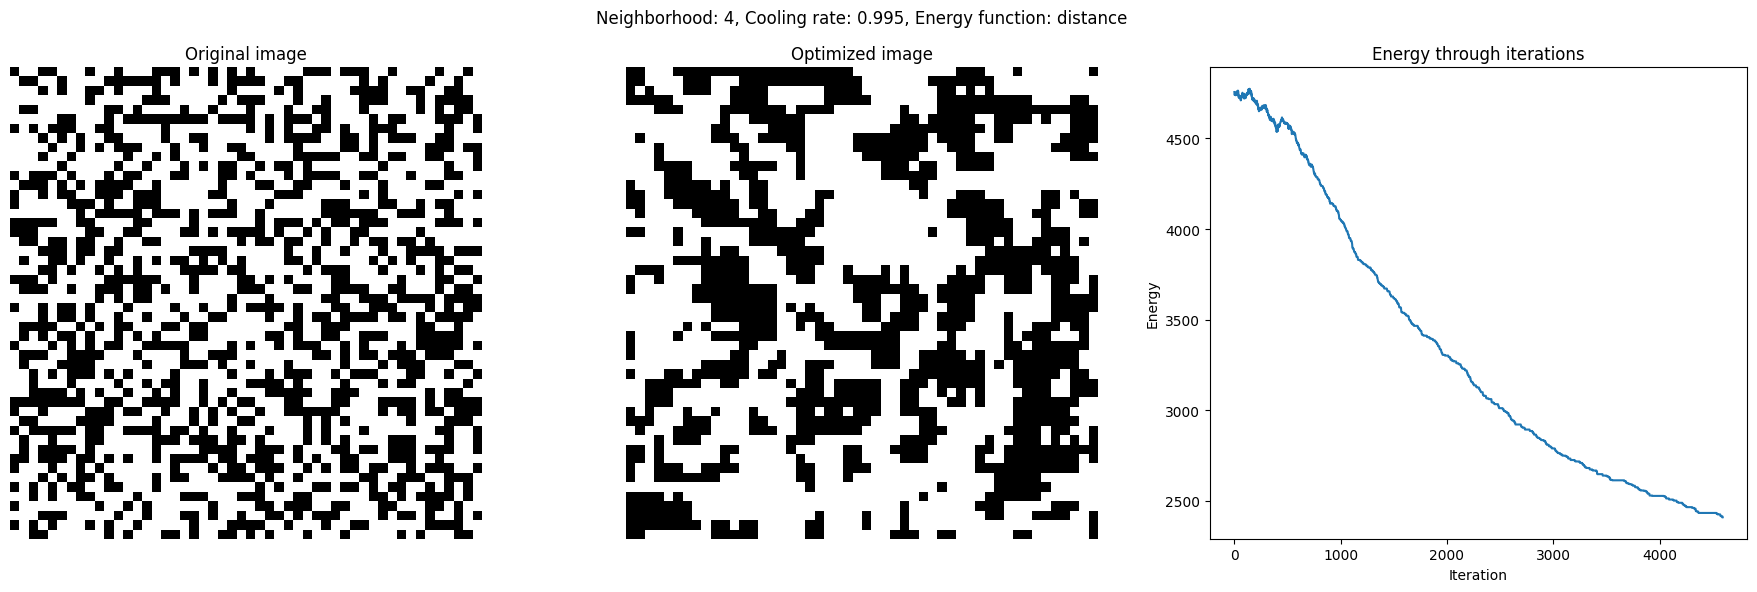

Neighborhood: 4, Cooling rate: 0.995, Energy function: vertical_neighbors
Initial energy: 2556.0
Final energy: 1102.0
Total elapsed time: 27.01 s



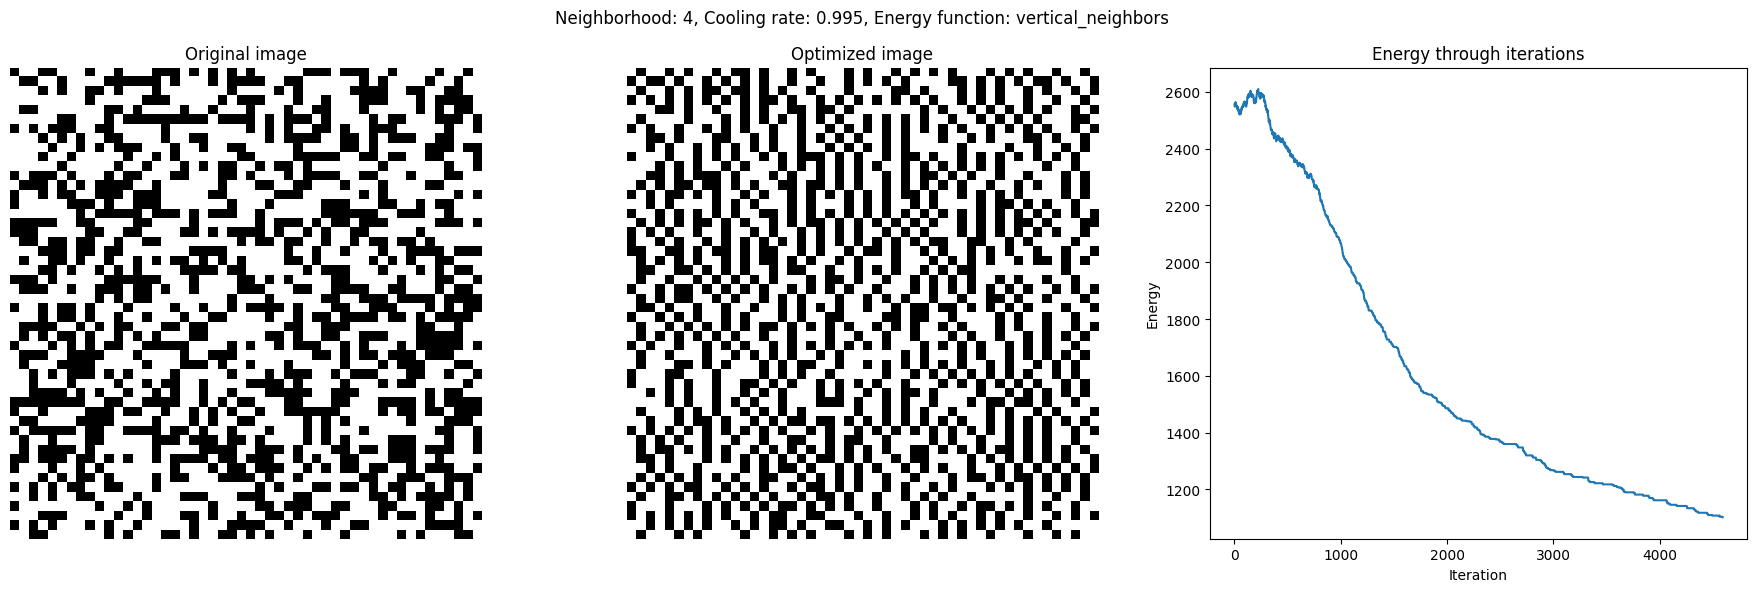

Neighborhood: 4, Cooling rate: 0.999, Energy function: clusters
Initial energy: 4756.0
Final energy: 1372.0
Total elapsed time: 162.79 s



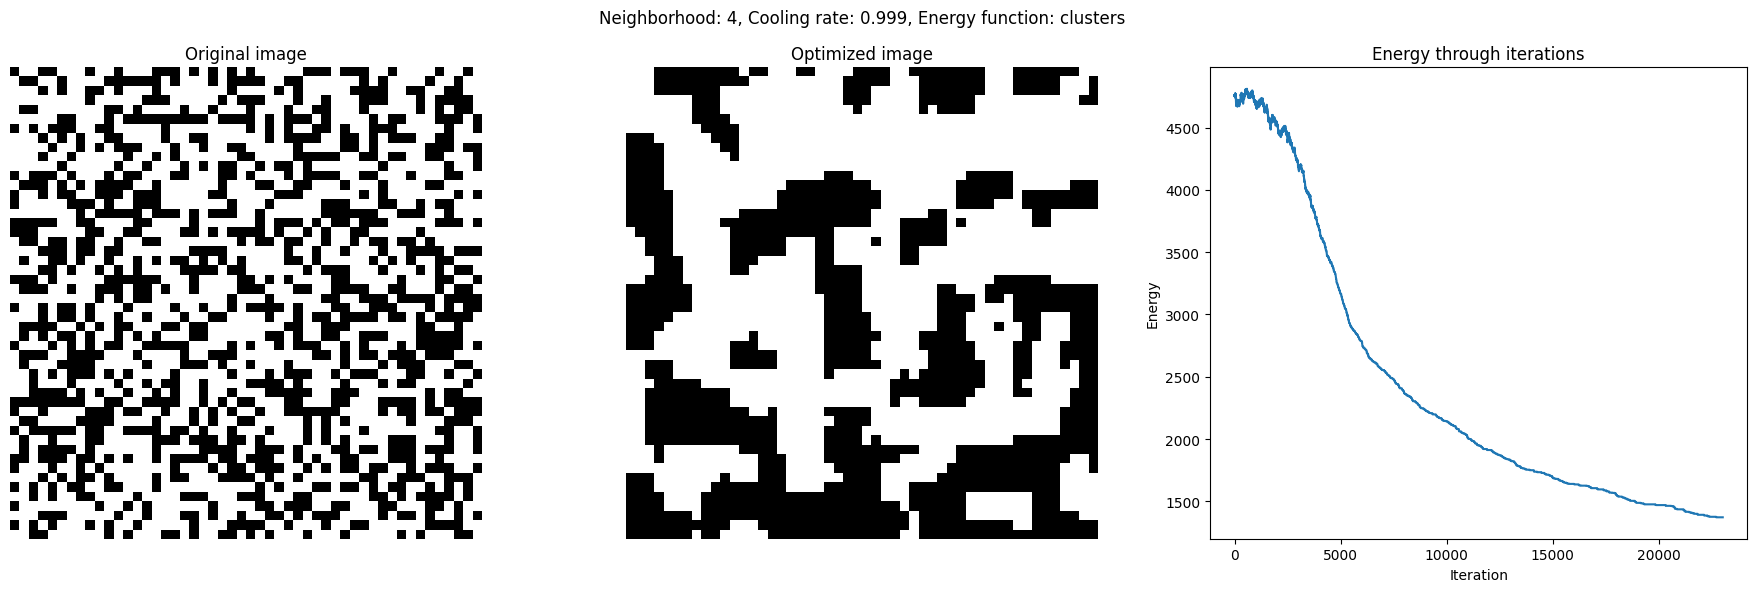

Neighborhood: 4, Cooling rate: 0.999, Energy function: distance
Initial energy: 4756.0
Final energy: 1286.0
Total elapsed time: 564.90 s



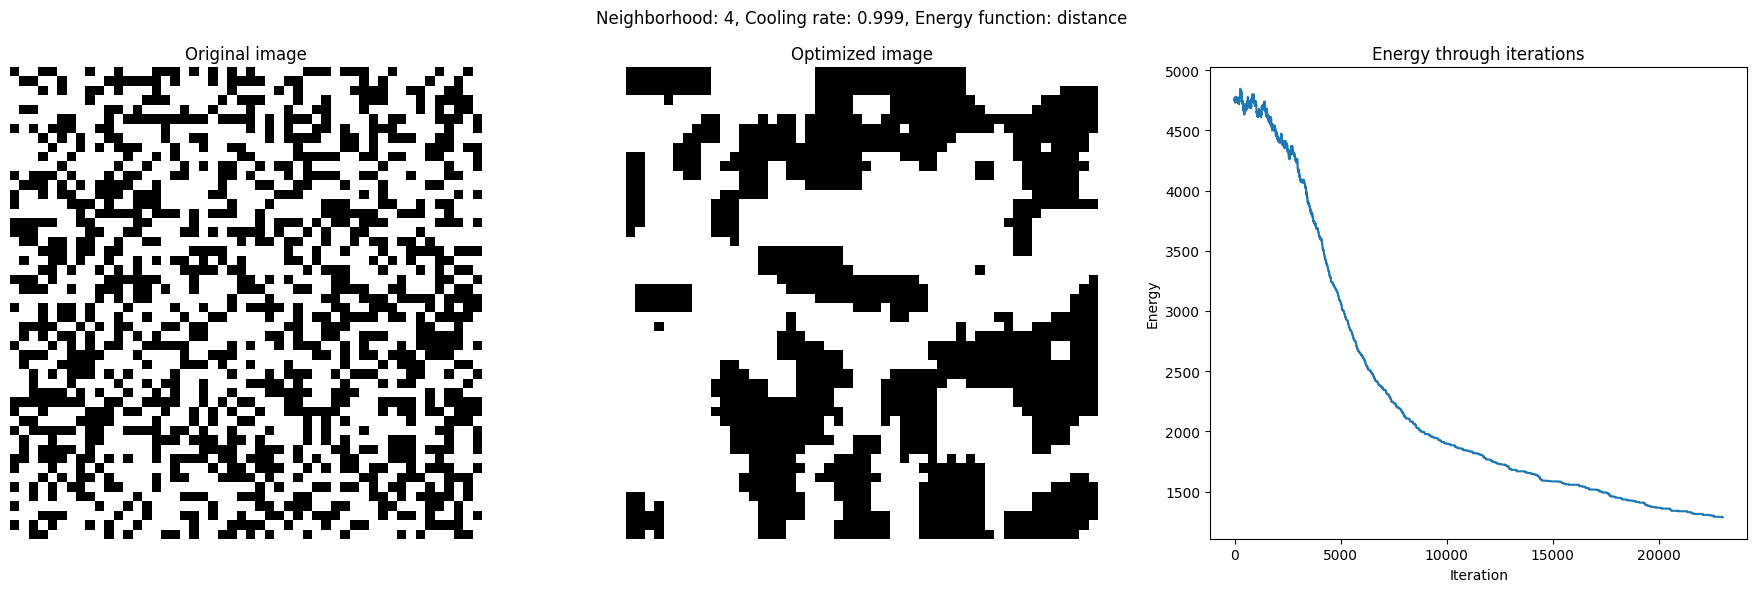

Neighborhood: 4, Cooling rate: 0.999, Energy function: vertical_neighbors
Initial energy: 2556.0
Final energy: 736.0
Total elapsed time: 134.12 s



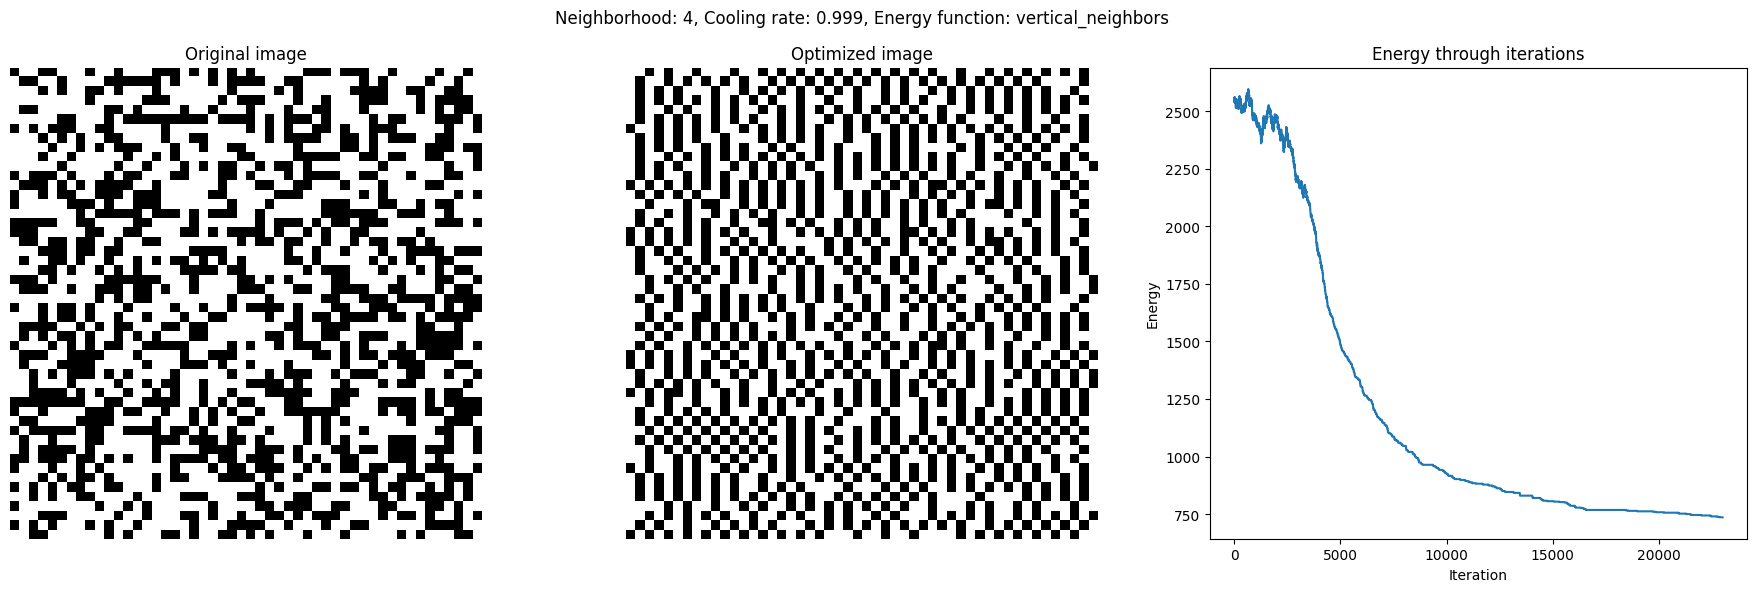

Neighborhood: 8, Cooling rate: 0.99, Energy function: clusters
Initial energy: 9442.0
Final energy: 6244.0
Total elapsed time: 25.46 s



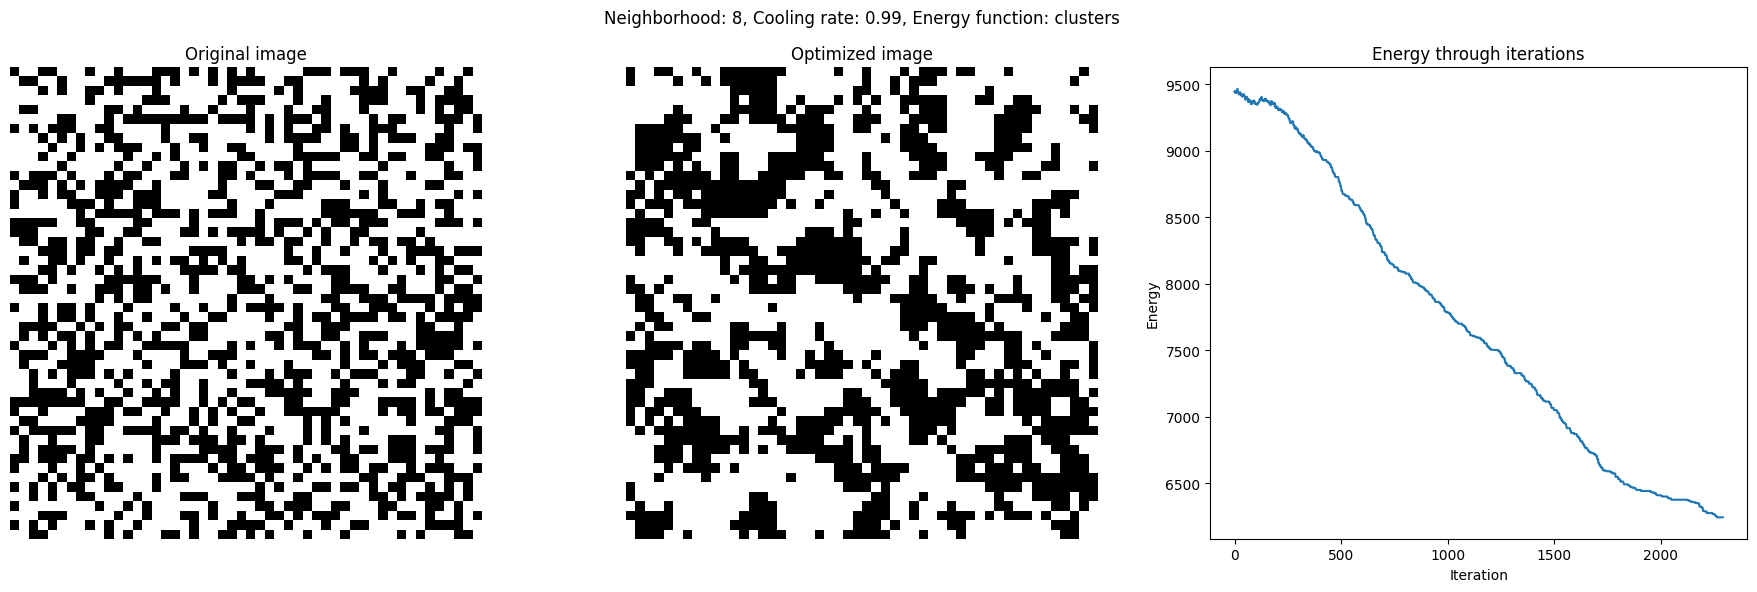

Neighborhood: 8, Cooling rate: 0.99, Energy function: distance
Initial energy: 8069.5023766405175
Final energy: 5218.72445585442
Total elapsed time: 106.00 s



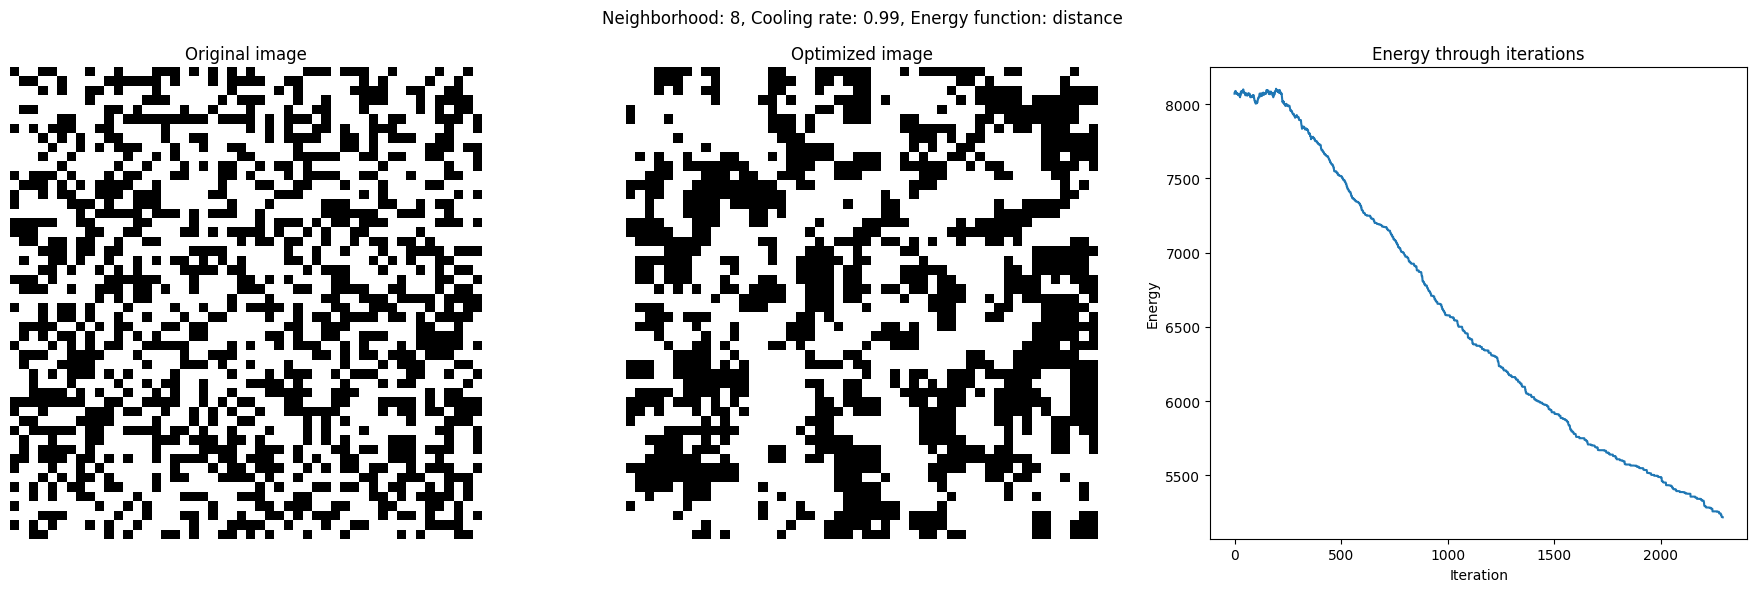

Neighborhood: 8, Cooling rate: 0.99, Energy function: vertical_neighbors
Initial energy: 7474.0
Final energy: 5228.0
Total elapsed time: 24.09 s



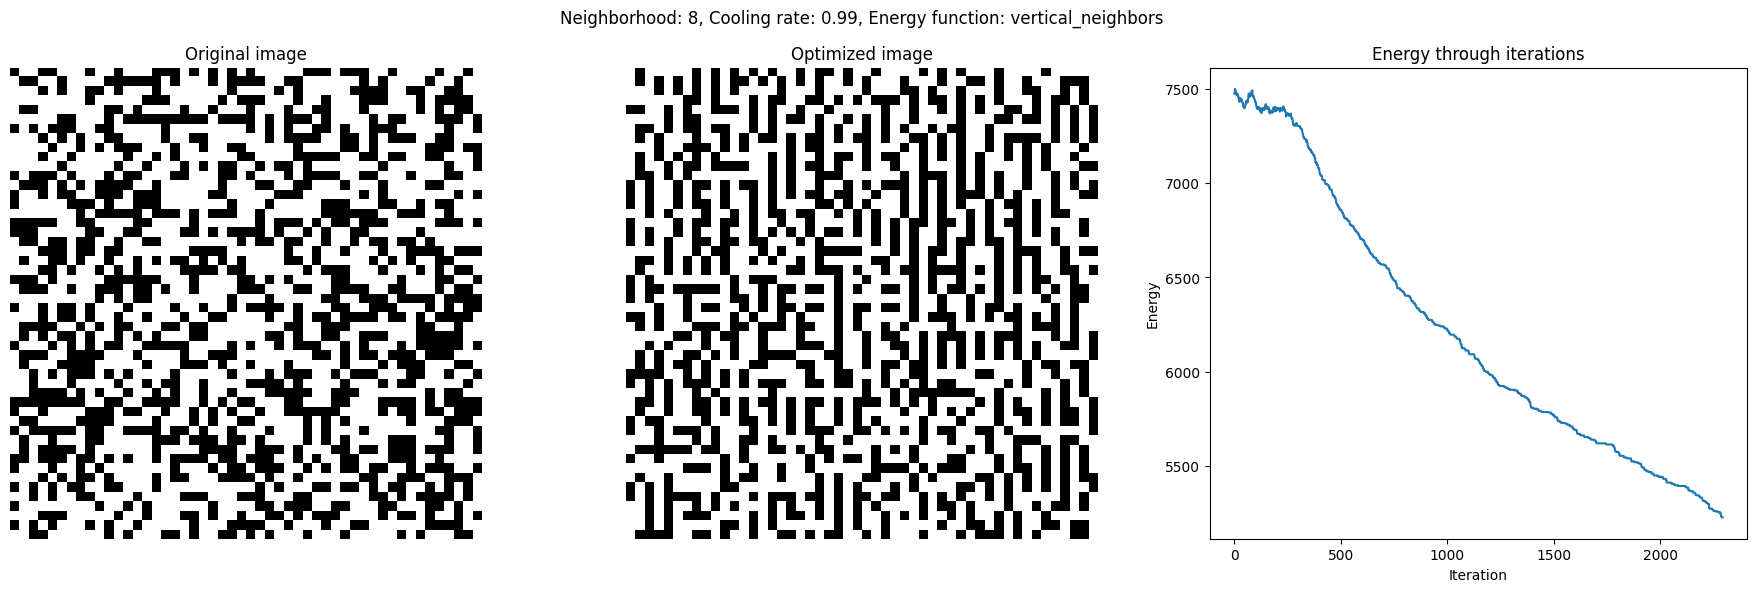

Neighborhood: 8, Cooling rate: 0.995, Energy function: clusters
Initial energy: 9442.0
Final energy: 5016.0
Total elapsed time: 52.17 s



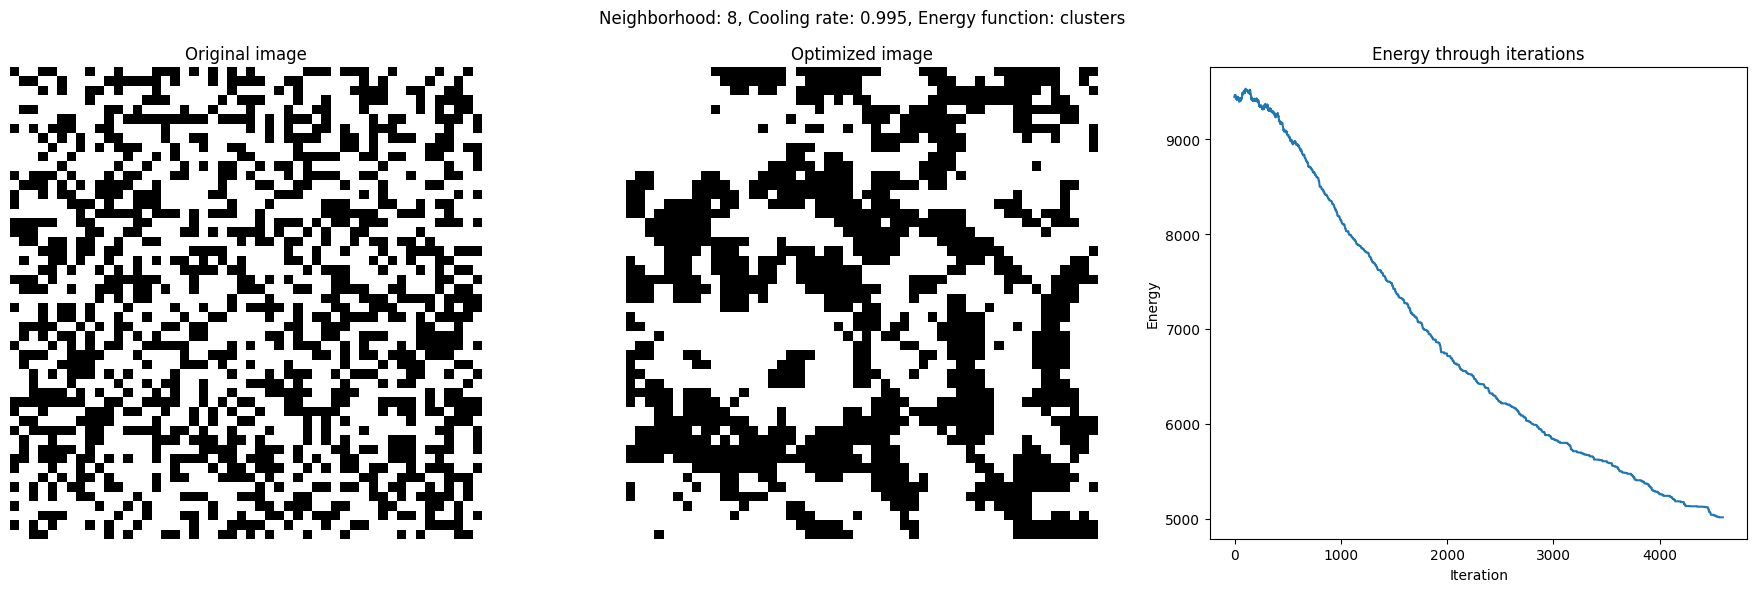

Neighborhood: 8, Cooling rate: 0.995, Energy function: distance
Initial energy: 8069.5023766405175
Final energy: 4094.460387142415
Total elapsed time: 210.82 s



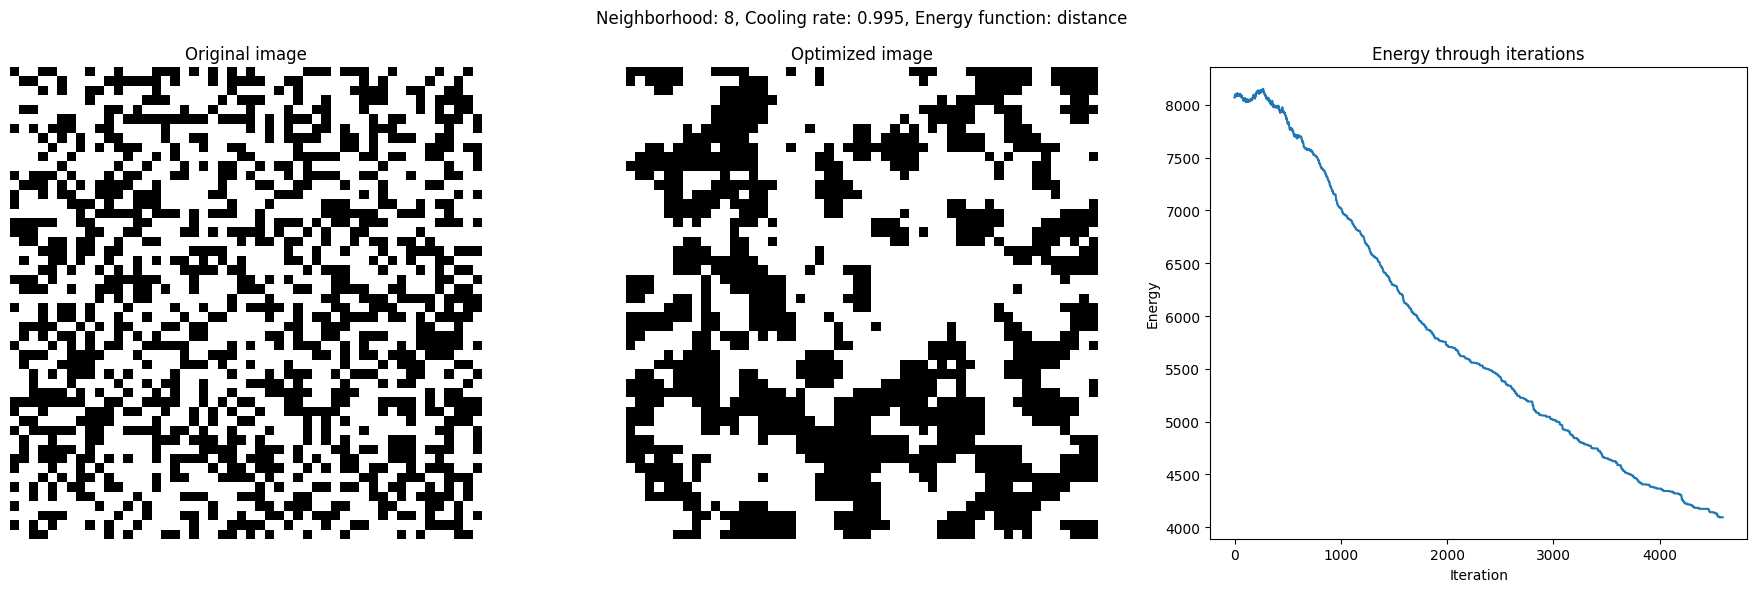

Neighborhood: 8, Cooling rate: 0.995, Energy function: vertical_neighbors
Initial energy: 7474.0
Final energy: 4162.0
Total elapsed time: 46.58 s



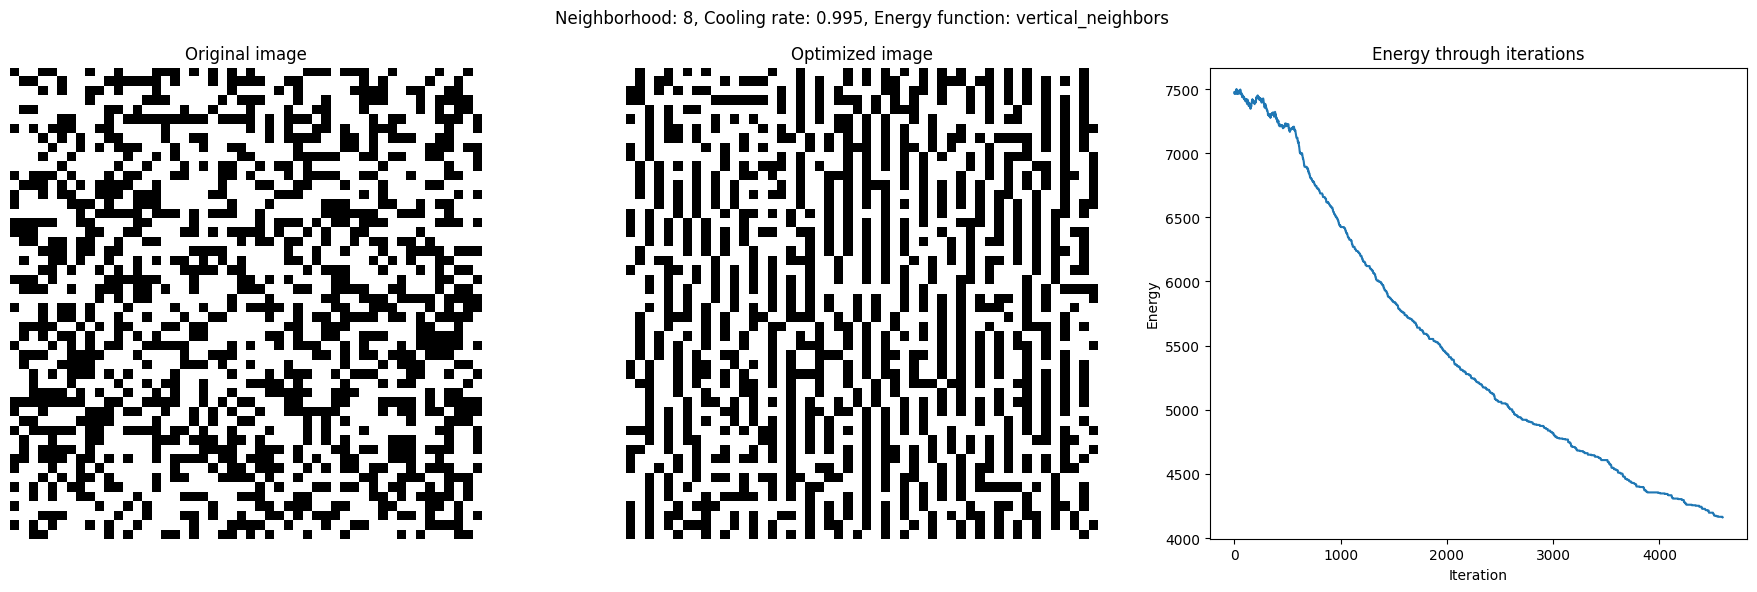

Neighborhood: 8, Cooling rate: 0.999, Energy function: clusters
Initial energy: 9442.0
Final energy: 2624.0
Total elapsed time: 253.55 s



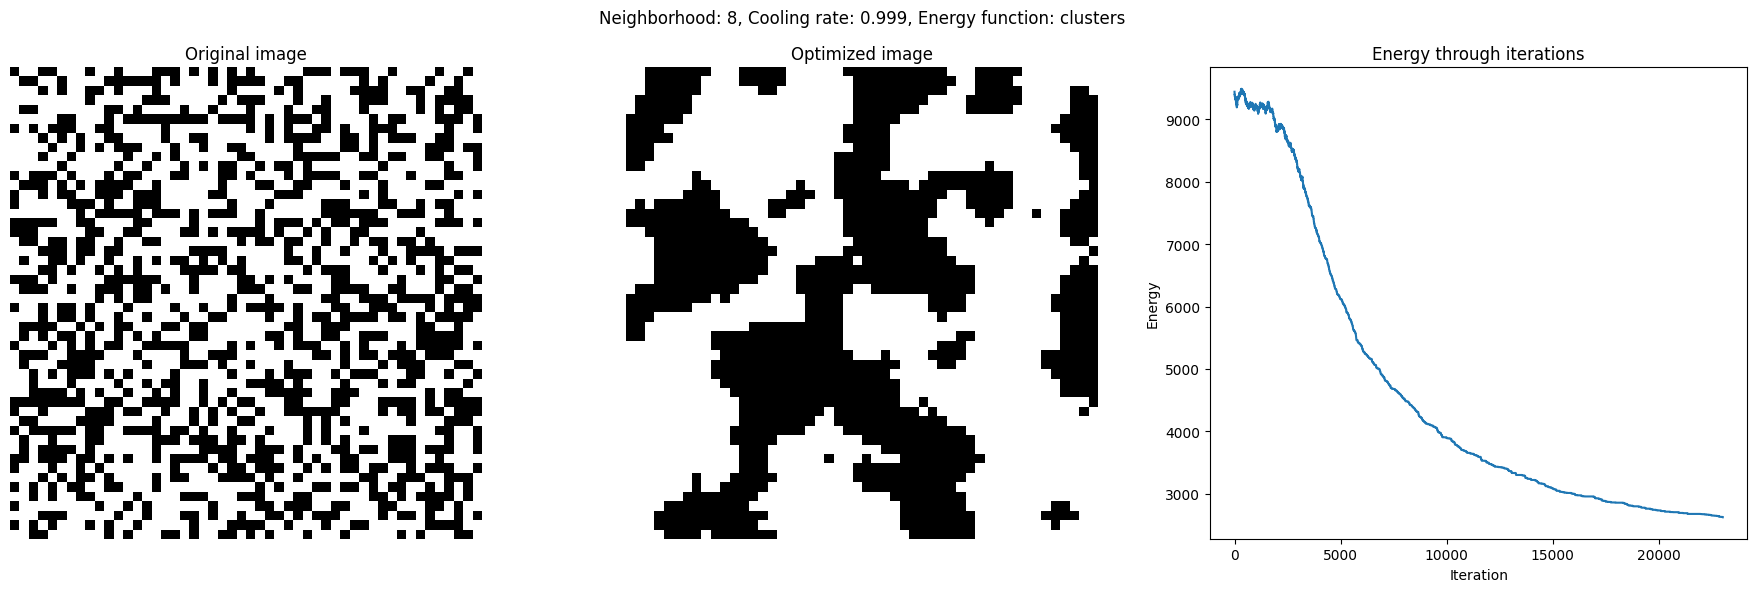

Neighborhood: 8, Cooling rate: 0.999, Energy function: distance
Initial energy: 8069.5023766405175
Final energy: 2300.0571413994385
Total elapsed time: 1045.06 s



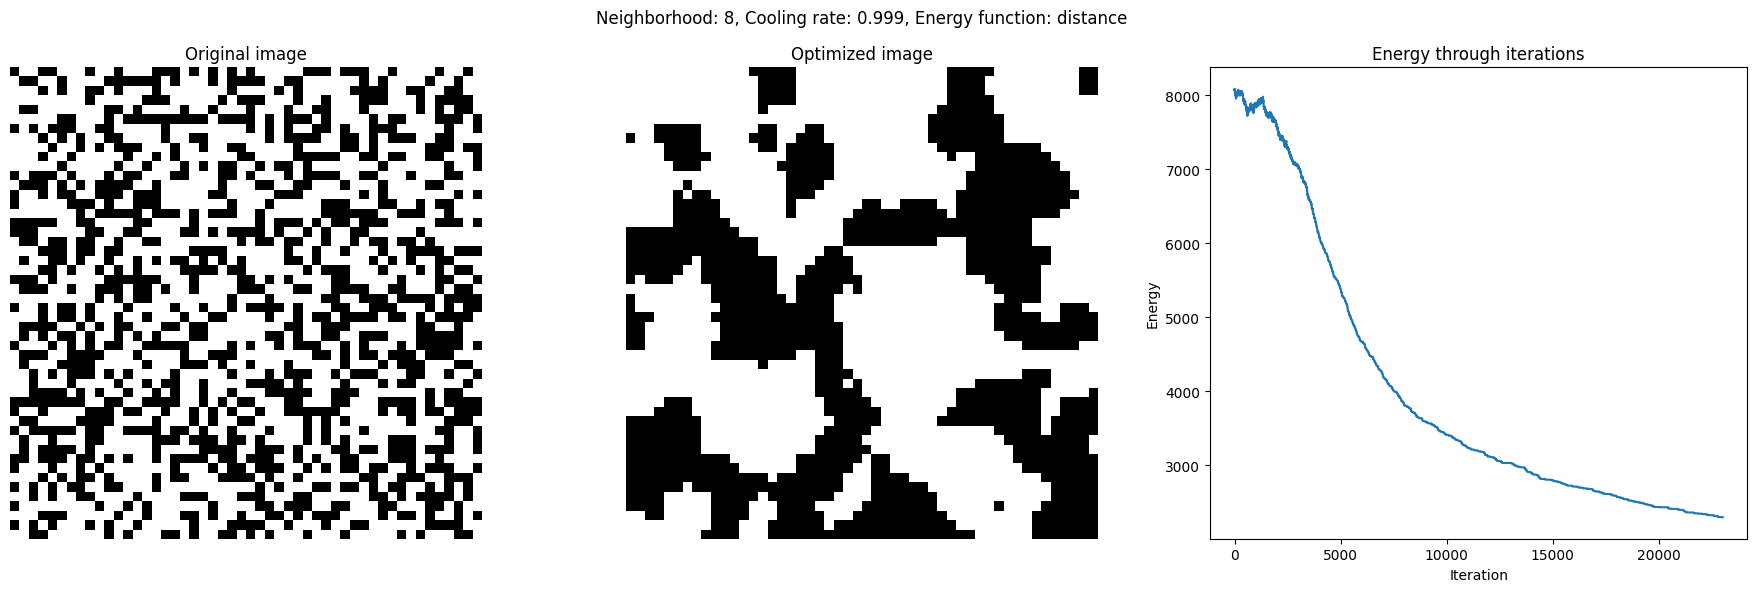

Neighborhood: 8, Cooling rate: 0.999, Energy function: vertical_neighbors
Initial energy: 7474.0
Final energy: 2608.0
Total elapsed time: 234.96 s



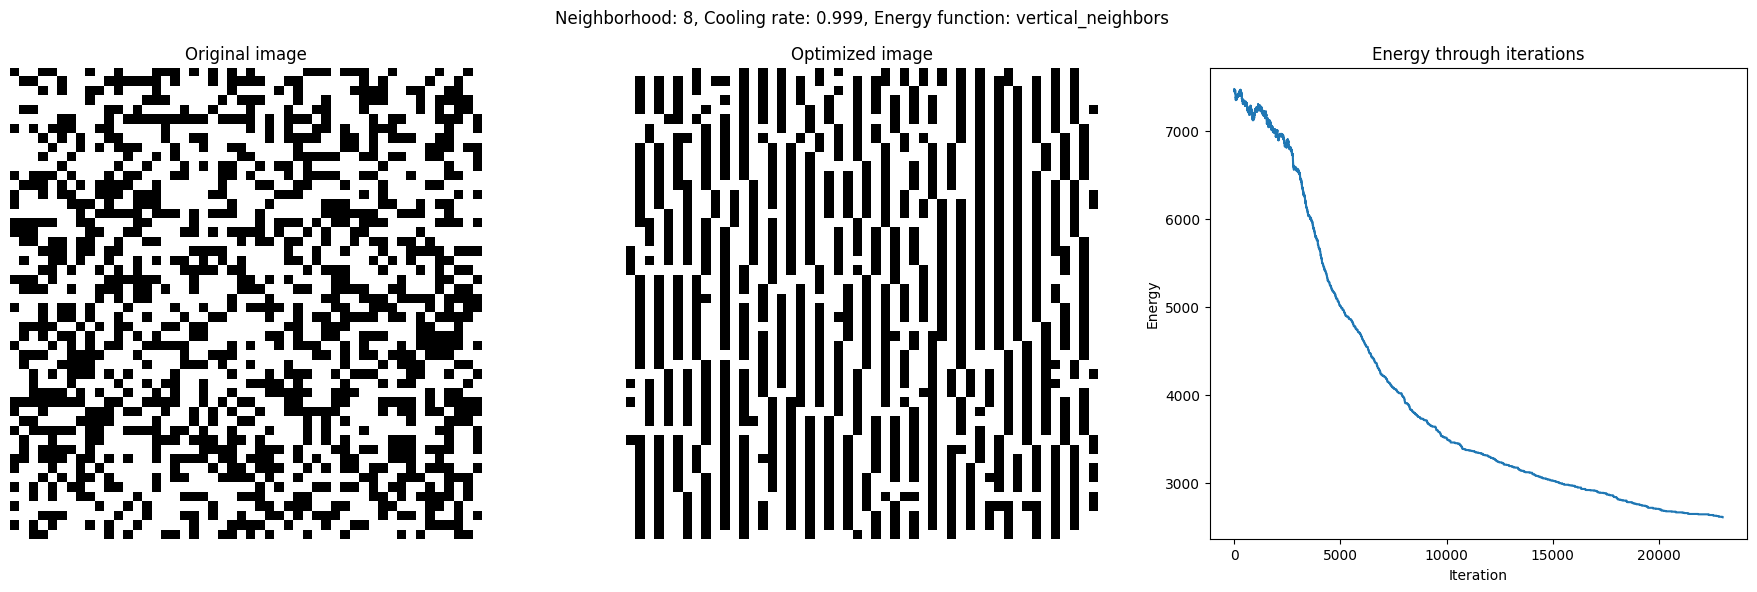

Neighborhood: 8-16, Cooling rate: 0.99, Energy function: clusters
Initial energy: 23118.0
Final energy: 16362.0
Total elapsed time: 52.52 s



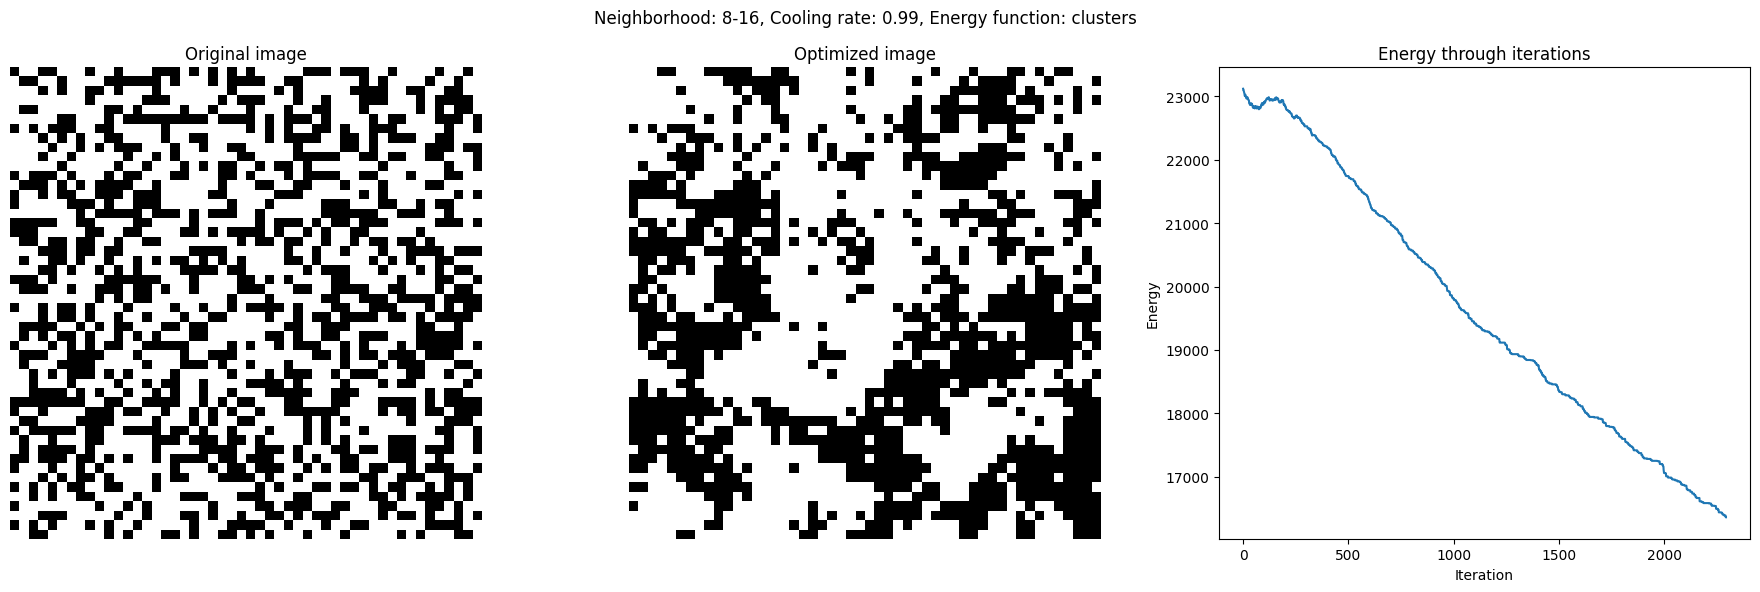

Neighborhood: 8-16, Cooling rate: 0.99, Energy function: distance
Initial energy: 14428.94083344466
Final energy: 10048.72613210696
Total elapsed time: 240.22 s



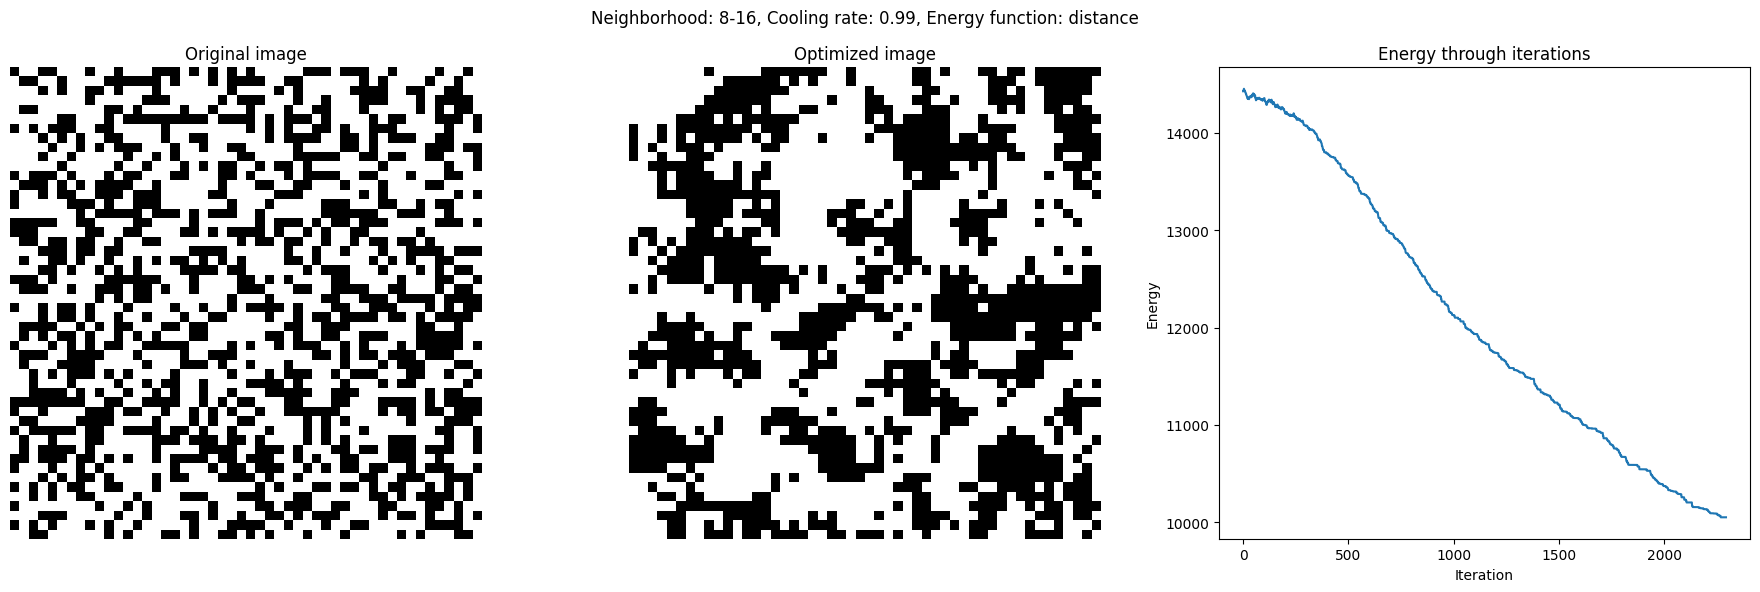

Neighborhood: 8-16, Cooling rate: 0.99, Energy function: vertical_neighbors
Initial energy: 19646.0
Final energy: 16298.0
Total elapsed time: 47.54 s



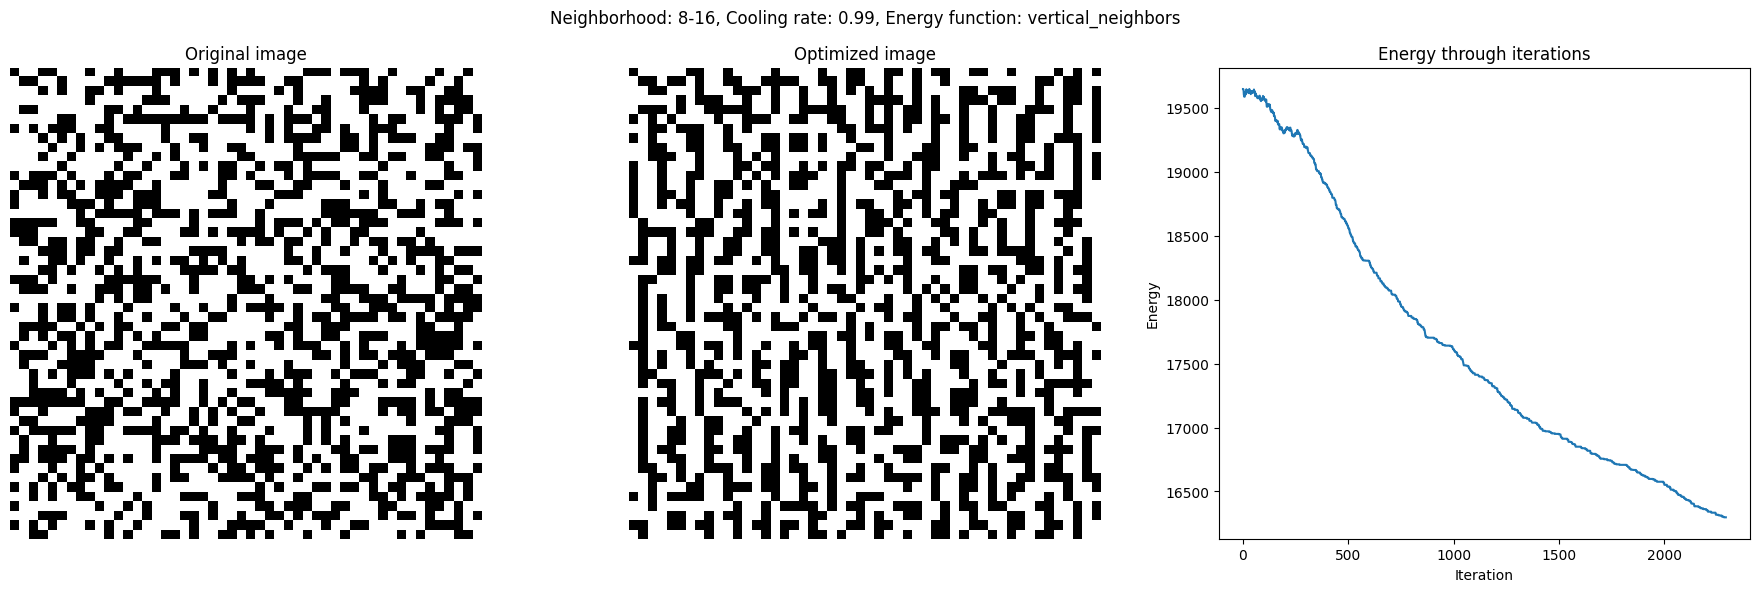

Neighborhood: 8-16, Cooling rate: 0.995, Energy function: clusters
Initial energy: 23118.0
Final energy: 12436.0
Total elapsed time: 103.11 s



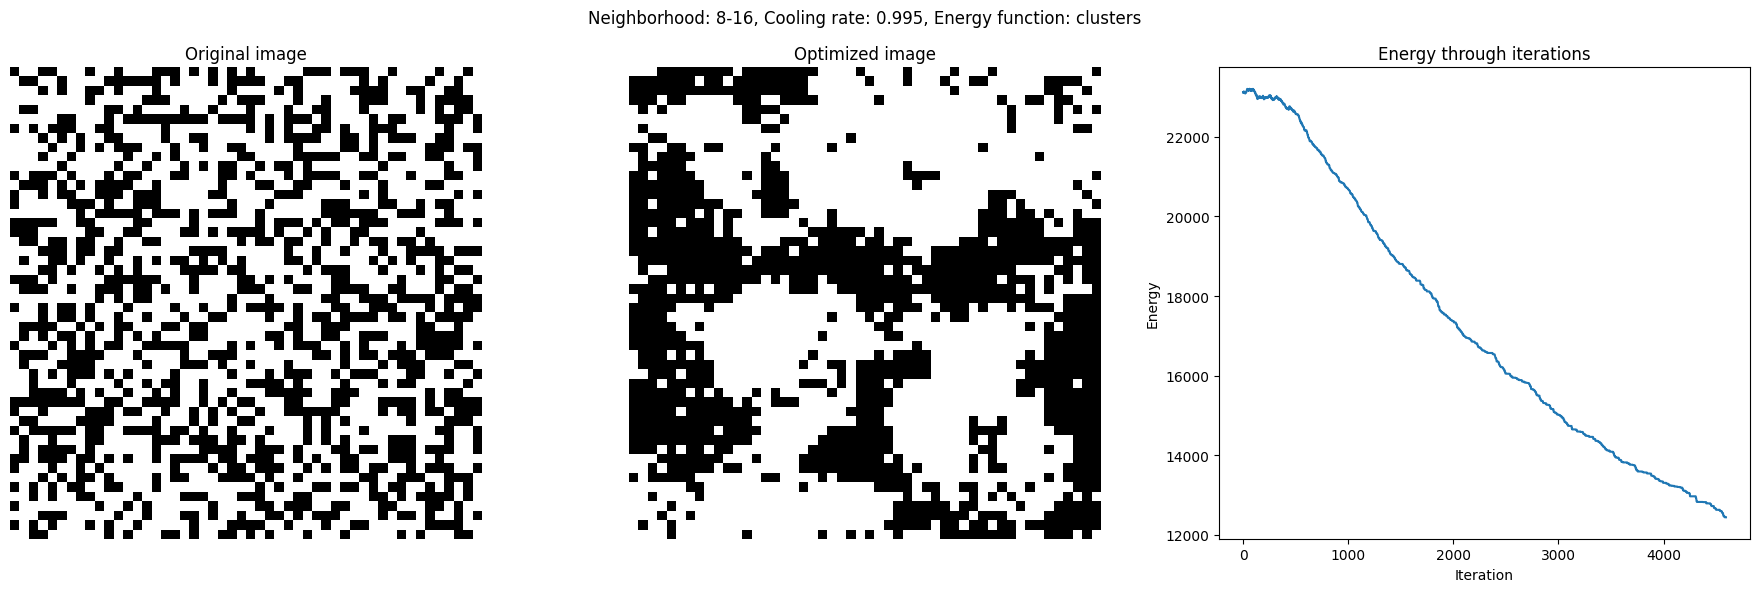

Neighborhood: 8-16, Cooling rate: 0.995, Energy function: distance
Initial energy: 14428.94083344466
Final energy: 7989.009884937926
Total elapsed time: 478.54 s



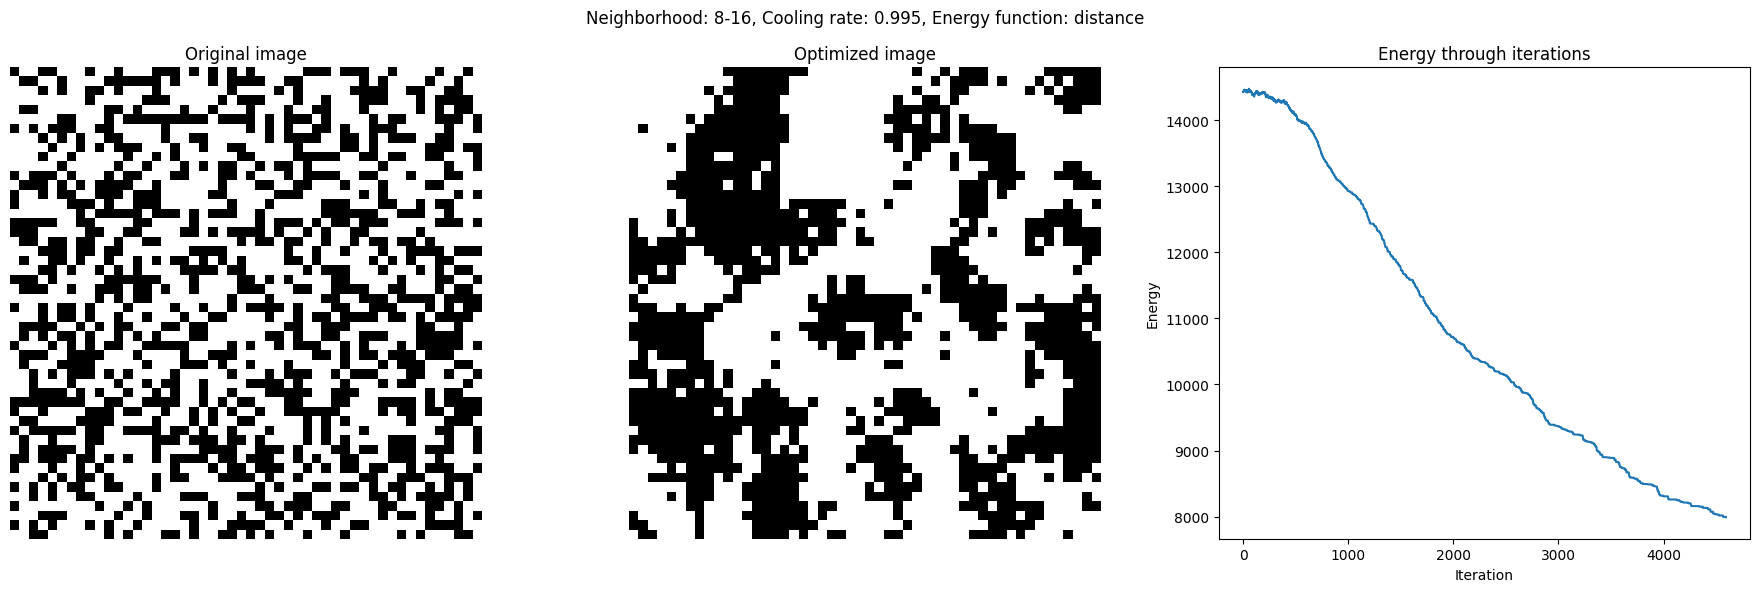

Neighborhood: 8-16, Cooling rate: 0.995, Energy function: vertical_neighbors
Initial energy: 19646.0
Final energy: 15228.0
Total elapsed time: 95.11 s



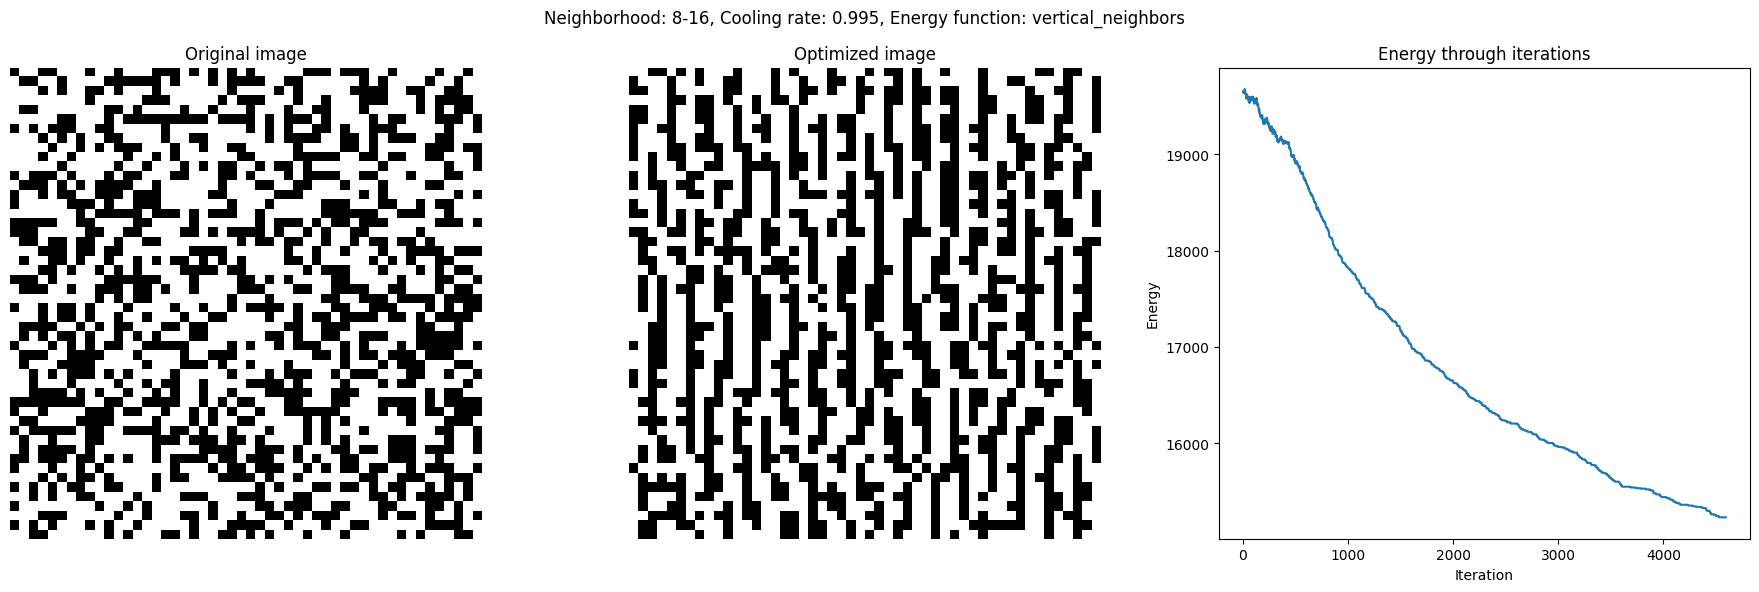

Neighborhood: 8-16, Cooling rate: 0.999, Energy function: clusters
Initial energy: 23118.0
Final energy: 5668.0
Total elapsed time: 522.19 s



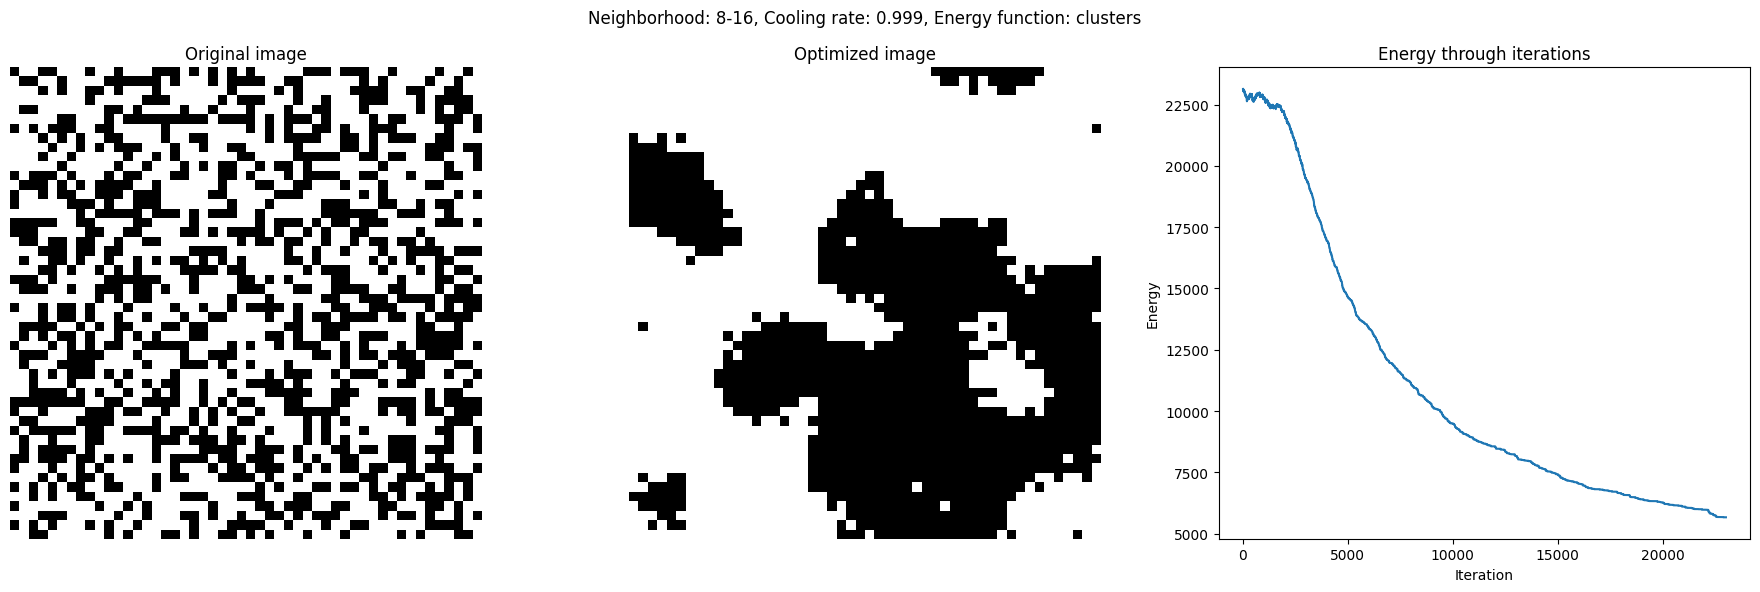

Neighborhood: 8-16, Cooling rate: 0.999, Energy function: distance
Initial energy: 14428.94083344466
Final energy: 3845.1200517114435
Total elapsed time: 2404.77 s



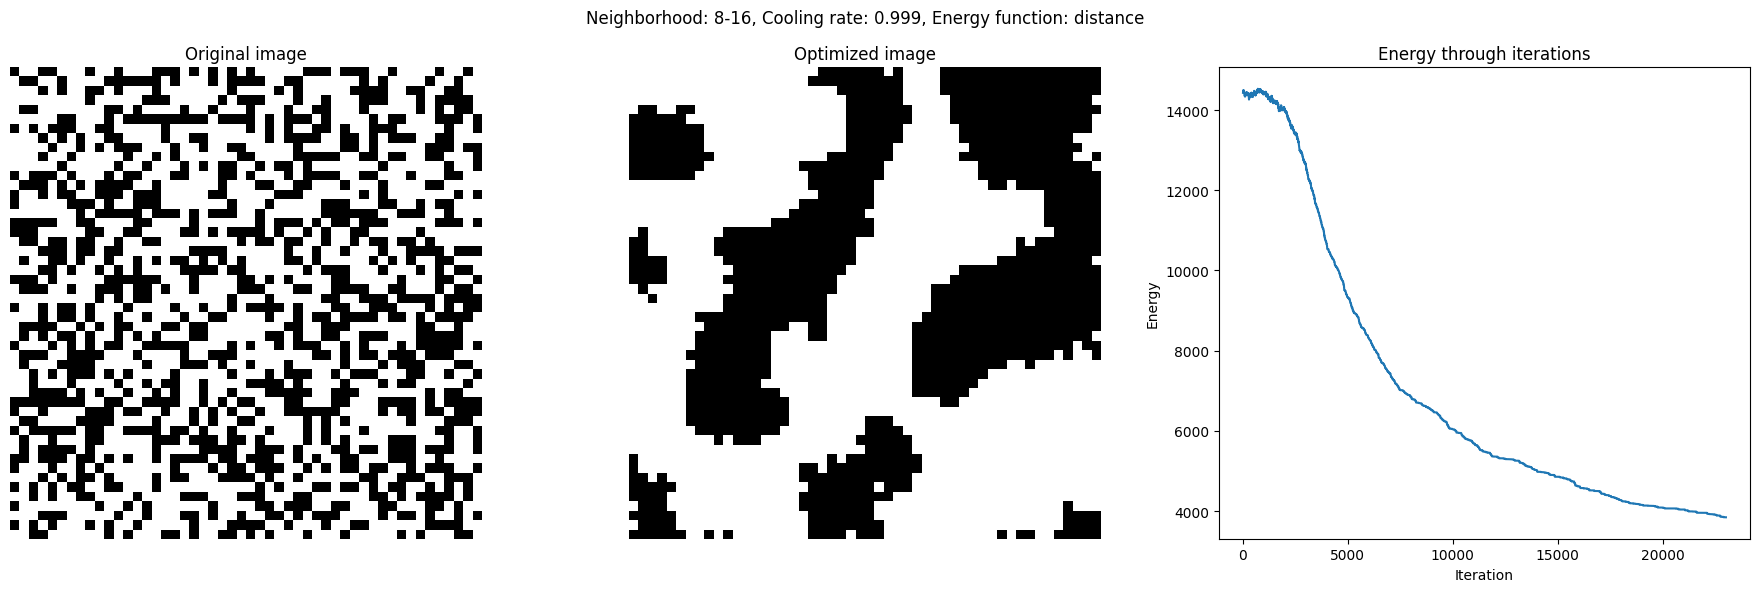

Neighborhood: 8-16, Cooling rate: 0.999, Energy function: vertical_neighbors
Initial energy: 19646.0
Final energy: 13338.0
Total elapsed time: 481.34 s



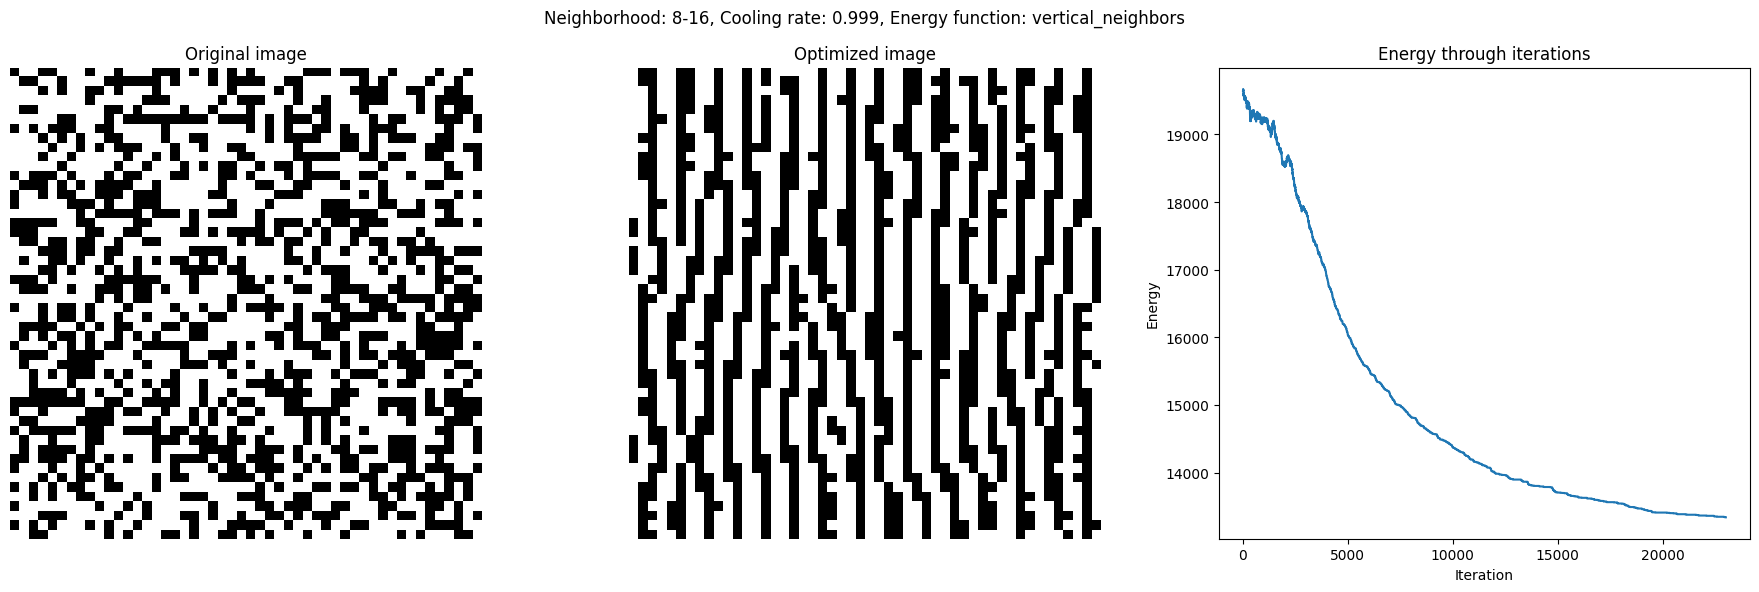

In [9]:
n = 50
density = 0.4
neighborhood_types = ['4', '8', '8-16']
cooling_rates = [0.99, 0.995, 0.999]
energy_functions = {
    'clusters': energy_clusters,
    'distance': energy_distance,
    'vertical_neighbors': energy_vertical_neighbors
    
}

original_image = generate_binary_image(n, density)

for neighborhood_type in neighborhood_types:
    for rate in cooling_rates:
        for energy_fn_name, energy_fn in energy_functions.items():
            start_time = time.time()
            optimized_image, energy_history = simulated_annealing(
                original_image,
                neighborhood_type,
                energy_function=energy_fn,
                cooling_rate=rate
            )
            elapsed_time = time.time() - start_time

            print(f"Neighborhood: {neighborhood_type}, Cooling rate: {rate}, Energy function: {energy_fn_name}")
            print(f"Initial energy: {energy_fn(original_image, neighborhood_type)}")
            print(f"Final energy: {energy_fn(optimized_image, neighborhood_type)}")
            print(f"Total elapsed time: {elapsed_time:.2f} s\n")

            visualize_results(original_image, optimized_image, energy_history,
                    f"Neighborhood: {neighborhood_type}, Cooling rate: {rate}, Energy function: {energy_fn_name}")

#### 6.2. Animacje

Animacje przetwarzania obrazów z wykorzystaniem różnych funkcji energii dla przykładowych parametrów:
- n = 100
- δ = 0.4
- 8-sąsiadów
- prędkość spadku temperatury - 0.999

In [16]:
original_image = generate_binary_image(100, 0.4)
for energy_fn_name, energy_fn in energy_functions.items():
    images = simulated_annealing_vis(
        original_image,
        '8',
        energy_function=energy_fn,
        cooling_rate=0.999,
        threshold=1e-8
    )
    print(f"Energy function: {energy_fn_name}")
    display(animate(images, energy_fn, '8', framerate=30))

Energy function: clusters
Creating animation...


Energy function: distance
Creating animation...


Energy function: vertical_neighbors
Creating animation...


### 6. Wnioski z eksperymentów

#### 6.1. **Typ sąsiedztwa**
- **4-sąsiadów**: Wolniejsze zmniejszanie energii (mniej interakcji między pikselami).
- **8-sąsiadów**: Szybsze zmniejszanie energii, bardzo gładkie obrazy.
- **8-16-sąsiadów**: Najszybsze zmniejszanie energii, lecz więcej artefaktów w porównaniu z 8-ma sąsiadami

#### 6.2. **Prędkość spadku temperatury**
- **0.99**: Szybkie działanie, ale mniej optymalne wyniki - algorytm często zatrzymuje się w minimum lokalnym.
- **0.995**: Dobry balans między czasem a jakością.
- **0.999**: Najlepsze wyniki, ale najdłuższy czas działania.

#### 6.3. **Funkcja energii**
- **`energy_clusters()`**: Obraz końcowy - zwarty układ klastrów czarnych pikseli.
- **`energy_distance()`**: Jednorodne obrazy z mniejszą liczbą klastrów.
- **`energy_vertical_neighbors()`**: Wyraźne pionowe struktury pikseli, szczególnie widoczne przy wolnym spadku temperatury i 8-miu sąsiadach.

#### 6.4. **Ogólne wnioski**
- Typ sąsiedztwa i funkcja energii wpływają na strukturę obrazu, a prędkość spadku temperatury na czas i dokładność.
- Wolny spadek temperatury (0.999) i 8-sąsiadów dają najlepsze wyniki, ale wymagają więcej czasu.